In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import re
import string
#!pip install C:\Users\aksha\Anaconda3\wordcloud‑1.3.3‑cp36‑cp36m‑win_amd64.whl
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
train_df = pd.read_table(r'D:\Kaggle\Mercari Price Suggestion\train.tsv')
#test_df = pd.read_table(r'D:\Kaggle\Mercari Price Suggestion\test.tsv')

In [3]:
print(train_df.shape)

(1482535, 8)


In [4]:
train_df.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


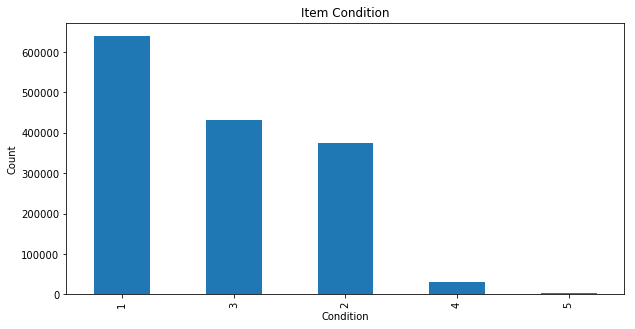

In [5]:
#Item_condition_id
plt.figure(figsize=(10, 5))
train_df['item_condition_id'].value_counts().plot(kind='bar')
plt.title('Item Condition')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

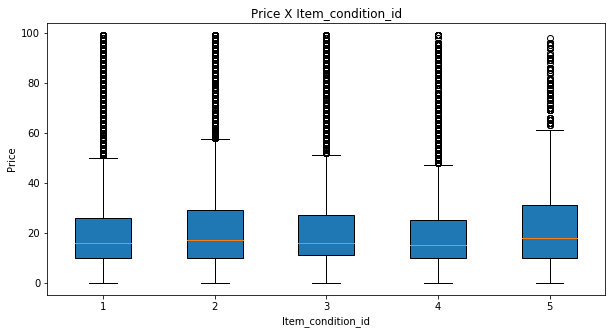

In [6]:
price = 100
df = train_df[train_df['price']<price]

box_plot = []
for i in train_df['item_condition_id'].unique():
    box_plot.append(df[df['item_condition_id']==i]['price'])

fig, axes = plt.subplots(figsize=(10, 5))
bp = axes.boxplot(box_plot,vert=True,patch_artist=True,labels=range(1,6)) 
plt.title('Price X Item_condition_id')
plt.xlabel('Item_condition_id')
plt.ylabel('Price')
plt.show()

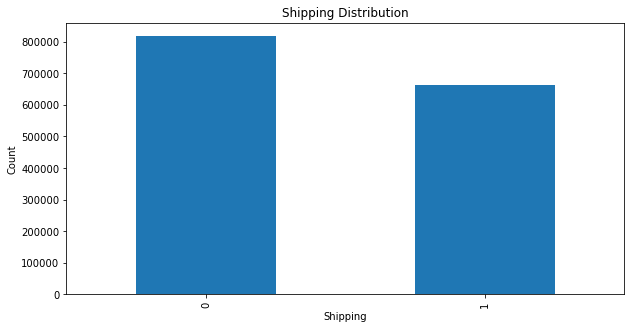

In [7]:
#shipping info
plt.figure(figsize=(10, 5))
train_df['shipping'].value_counts().plot(kind='bar')
plt.title('Shipping Distribution')
plt.xlabel('Shipping')
plt.ylabel('Count')
plt.show()

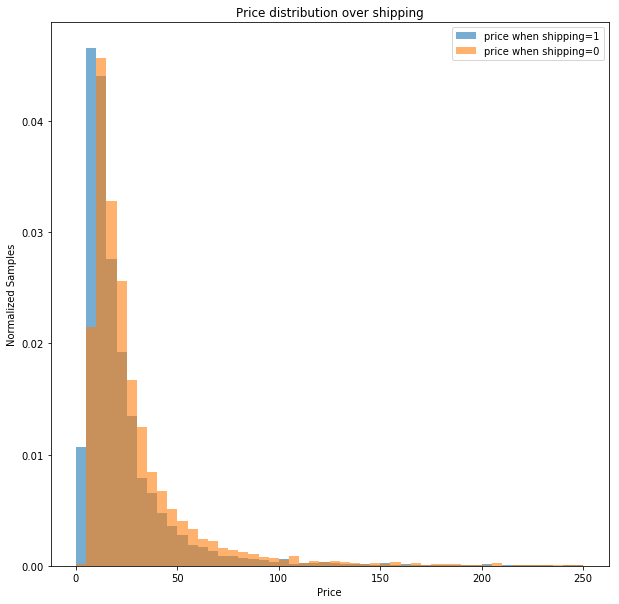

In [38]:
#Price distribution over shipping

plt.figure(figsize=(10, 10))
bins=50
x = train_df[train_df['shipping']==1]['price']
y = train_df[train_df['shipping']==0]['price']
plt.hist(x, bins, normed=True, range=[0,250], alpha = 0.6, label='price when shipping=1')
plt.hist(y, bins, normed=True, range=[0,250], alpha = 0.6, label='price when shipping=0')
plt.title('Price distribution over shipping')
plt.xlabel('Price')
plt.ylabel('Normalized Samples')
plt.legend()
plt.show()

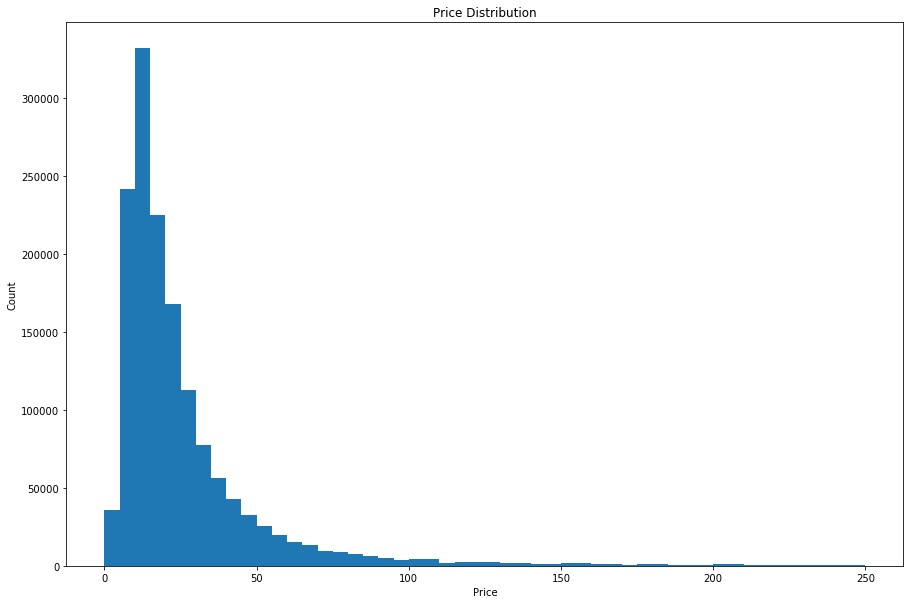

In [9]:
#price

plt.figure(figsize=(15, 10))
plt.hist(train_df.price, bins = 50, range = [0,250], label = 'price')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

#right skewed

In [10]:
#unique category names
train_df.category_name.nunique()

1287

In [11]:
# no of items with no label
train_df.category_name.shape[0] - train_df.category_name.dropna().shape[0]

6327

In [12]:
#split into sub categories
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [13]:
train_df['general_cat'], train_df['subcat_1'], train_df['subcat_2'] = \
zip(*train_df['category_name'].apply(lambda x: split_cat(x)))

In [14]:
print("There are %d unique categories." % train_df['general_cat'].nunique())
print("There are %d unique first sub-categories." % train_df['subcat_1'].nunique())
print("There are %d unique second sub-categories." % train_df['subcat_2'].nunique())

There are 11 unique categories.
There are 114 unique first sub-categories.
There are 871 unique second sub-categories.


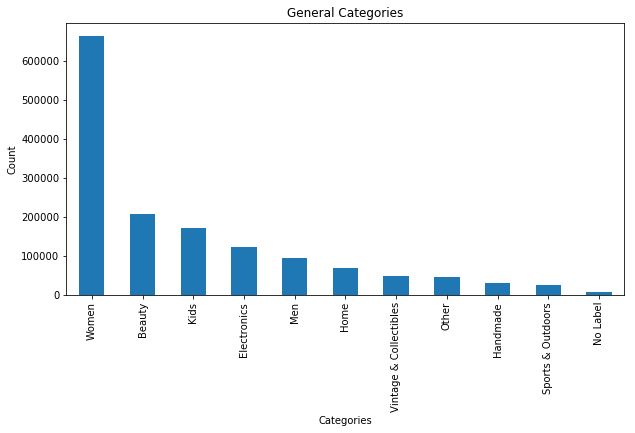

In [15]:
#general category
plt.figure(figsize=(10, 5))
train_df['general_cat'].value_counts().plot(kind='bar')
plt.title('General Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()


In [16]:
# general_cat == No label

#train_df.groupby([train_df['general_cat']=='No Label'])['item_condition_id'].value_counts(sort = False)

#          general_cat  item_condition_id                 general_cat  item_condition_id
#False        1                    638324       True         1                      2225
#             2                    373302                    2                      2177
#             3                    430402                    3                      1757
#             4                     31803                    4                       157
#             5                      2373                    5                        11

#train_df.groupby([train_df['general_cat']=='No Label'])['price'].describe()

#False        min      0.000000e+00         True         min      0.000000e+00
#             25%      1.000000e+01                      25%      1.000000e+01
#             50%      1.700000e+01                      50%      1.600000e+01
#             75%      2.900000e+01                      75%      2.800000e+01
#             max      2.009000e+03                      max      1.000000e+03

#train_df.groupby([train_df['general_cat']=='No Label'])['shipping'].value_counts(sort = False)

#          general_cat  shipping                 general_cat  shipping
#False        0           815413       True         0             4019
#             1           660791                    1             2308             
#             


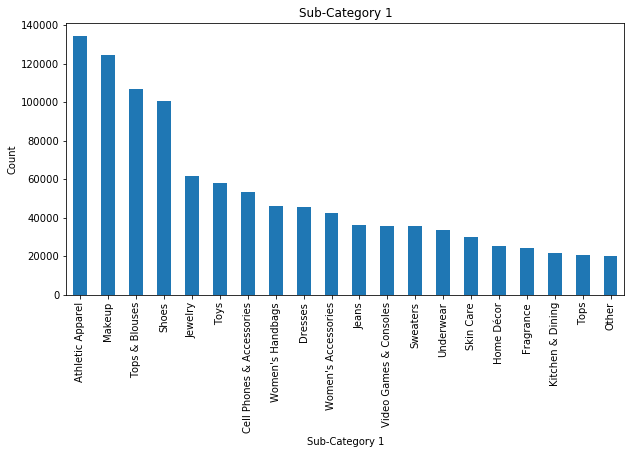

In [17]:
#Sub_category_1

plt.figure(figsize=(10, 5))
train_df['subcat_1'].value_counts()[:20].plot(kind='bar')
plt.title('Sub-Category 1')
plt.xlabel('Sub-Category 1')
plt.ylabel('Count')
plt.show()

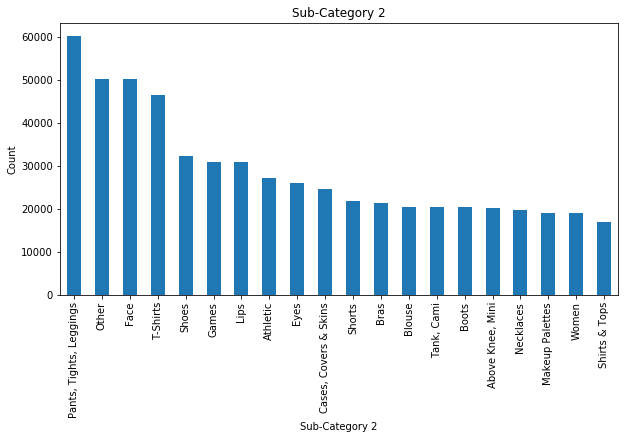

In [18]:
#Sub_category_2

plt.figure(figsize=(10, 5))
train_df['subcat_2'].value_counts()[:20].plot(kind='bar')
plt.title('Sub-Category 2')
plt.xlabel('Sub-Category 2')
plt.ylabel('Count')
plt.show()

In [19]:
#brand_name
train_df.brand_name.nunique()

4809

In [20]:
#item description

#remove observations with null item_description
train_df = train_df[pd.notnull(train_df['item_description'])]

In [21]:
def preprocess(text):
    
    #stop words
    stop_words = set(stopwords.words('english'))
    
    # remove punctuation
    regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    text = regex.sub(" ", text) 
    
    #tokenize
    tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
    tokens = []
    for token_by_sent in tokens_:
        tokens += token_by_sent
    tokens = list(filter(lambda t: t.lower() not in stop_words, tokens))
    filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
    
    #words > 3 since tokenization outputs single char words too
    filtered_tokens = [w.lower() for w in filtered_tokens if len(w) >= 3]
    
    return filtered_tokens

In [22]:
# apply the tokenizer
train_df['tokens'] = train_df['item_description'].map(preprocess)

In [23]:
#test tokenizer
for desc, tokens in zip(train_df['item_description'].head(), train_df['tokens'].head()):
    print('description:', desc)
    print('tokens:', tokens)
    print()

description: No description yet
tokens: ['description', 'yet']

description: This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
tokens: ['keyboard', 'great', 'condition', 'works', 'like', 'came', 'box', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'via', 'razer', 'synapse', 'app']

description: Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!
tokens: ['adorable', 'top', 'hint', 'lace', 'key', 'hole', 'back', 'pale', 'pink', 'also', 'available', 'white']

description: New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
tokens: ['new', 'tags', 'leather', 'horses', 'retail', 'stand', 'foot', 'high', 'sold', 'pair', 'questions', 'please', 

In [24]:
#high frequency words within general_category
category = dict()
for cat in train_df.general_cat.unique(): 
    text = " ".join(train_df.loc[train_df['general_cat']==cat, 'item_description'].values)
    category[cat] = preprocess(text)
    
women = Counter(category['Women']).most_common(50)
beauty = Counter(category['Beauty']).most_common(50)                   
electronics = Counter(category['Electronics']).most_common(50)               
handmade = Counter(category['Handmade']).most_common(50)                 
home = Counter(category['Home']).most_common(50)                   
kids = Counter(category['Kids']).most_common(50)                    
men = Counter(category['Men']).most_common(50)                     
NoLabel = Counter(category['No Label']).most_common(50)                 
other = Counter(category['Other']).most_common(50)                    
SportsOutdoors = Counter(category['Sports & Outdoors']).most_common(50)        
VintageCollectibles = Counter(category['Vintage & Collectibles']).most_common(50)

In [25]:
def generate_wordcloud(gene_cat):
    wordcloud = WordCloud(background_color='black', random_state = 1).generate(str(gene_cat))
    return wordcloud

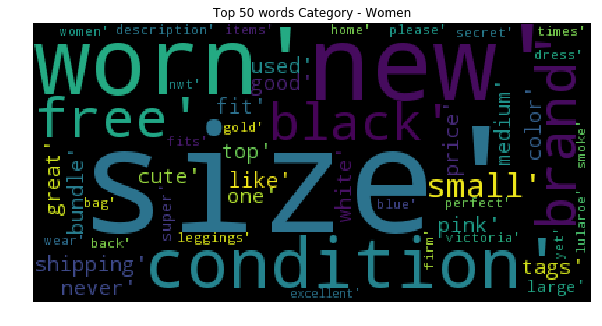

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(generate_wordcloud(women))
plt.title('Top 50 words Category - Women')
plt.axis('off')
plt.show()

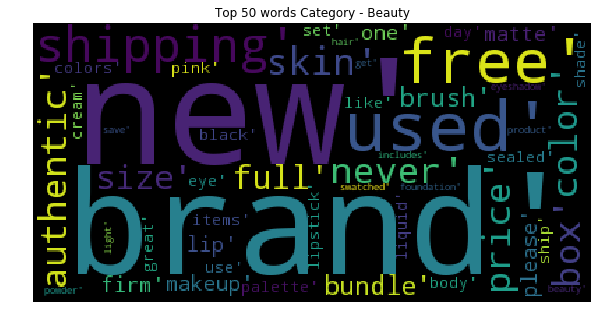

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(generate_wordcloud(beauty))
plt.title('Top 50 words Category - Beauty')
plt.axis('off')
plt.show()

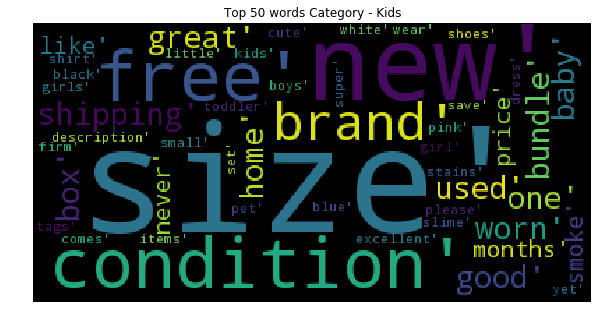

In [28]:
plt.figure(figsize=(10, 10))
plt.imshow(generate_wordcloud(kids))
plt.title('Top 50 words Category - Kids')
plt.axis('off')
plt.show()

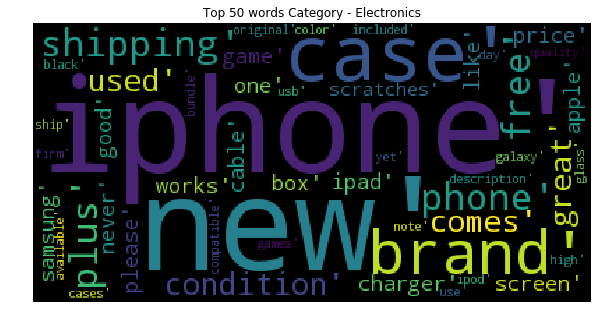

In [29]:
plt.figure(figsize=(10, 10))
plt.imshow(generate_wordcloud(electronics))
plt.title('Top 50 words Category - Electronics')
plt.axis('off')
plt.show()

In [30]:
#Tfidf
vec = TfidfVectorizer()
vec.fit_transform(train_df['item_description'].values)

<1482531x162032 sparse matrix of type '<class 'numpy.float64'>'
	with 30586189 stored elements in Compressed Sparse Row format>

In [31]:
tfidf = dict(zip(vec.get_feature_names(), vec.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [32]:
#Most used words with lowest tfidf score
tfidf.sort_values(by = ['tfidf'], ascending=True).head(5)

,tfidf
and,2.090601
new,2.171209
size,2.326832
in,2.351539
for,2.428637


In [33]:
#unique words with higher tfidf score
tfidf.sort_values(by = ['tfidf'], ascending = False).head(5)

,tfidf
ｗｉｌｄｆｏｘ,14.516115
frau,14.516115
safespace,14.516115
safestreet,14.516115
safesync,14.516115


In [34]:
#CountVectorizer
cv = CountVectorizer()
cvec = cv.fit_transform(train_df['item_description'])

In [35]:
#LDA
lda = LatentDirichletAllocation(n_topics = 10, max_iter = 1, learning_method = 'online', learning_offset = 50.,random_state = 1)
topics = lda.fit_transform(cvec)

In [36]:
topic_words = lda.components_
vocab = cv.get_feature_names()

In [37]:
topic_summaries = []
words = 10

for i, topic in enumerate(topic_words):
    topic_word = np.array(vocab)[np.argsort(topic)][:-(words+1):-1]
    topic_summaries.append(' '.join(topic_word))
    print('Topic {}: {}'.format(i, ' | '.join(topic_word)))

Topic 0: and | of | to | for | the | with | your | skin | hair | 15
Topic 1: pink | and | size | with | black | new | blue | white | secret | victoria
Topic 2: for | you | to | shipping | will | rm | please | bundle | free | my
Topic 3: new | brand | rm | in | price | never | used | box | free | is
Topic 4: size | with | and | small | new | medium | top | worn | tags | black
Topic 5: with | and | iphone | for | case | bag | gold | new | silver | plus
Topic 6: the | in | of | and | are | is | on | has | but | they
Topic 7: it | the | to | and | for | is | this | you | can | so
Topic 8: no | description | yet | oz | body | fl | bath | bottle | scent | lotion
Topic 9: condition | size | worn | no | free | in | great | good | home | smoke
